# Detecção de anomalias: métodos baseados em proximidade_, examinamos maneiras de sinalizar anomalias usando vários métodos baseados em distância. Em particular, analisamos os pontos de sinalização usando
- métodos baseados na distância: anomalias são pontos "distantes" de outros pontos
- métodos de agrupamento: anomalias são pontos que estão nas bordas do cluster / não atribuídos a um cluster
- métodos baseados em densidade: anomalias são pontos com menos vizinhos que pontos típicos na mesma região.

# Resultados de aprendizagem

Você deve sair deste notebook com a capacidade de
1. Faça um detector de anomalia kNN (baseado em distância)
2. Faça um detector de anomalia k-means (baseado em cluster)
3. Use o Fator Outlier Local para classificar anomalias
# Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

# Python and library versions

In [2]:
packages = [np]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]

library .      version
-------        -------
numpy           1.18.5


# Seção 1: Métodos baseados em distância

O método mais simples de vizinho mais próximo (NN) é levar a distância até o vizinho mais próximo k como a pontuação da anomalia. A próxima variação é usar a média das distâncias para os principais vizinhos de k como a pontuação. `sklearn` fornece` neighbours.NearestNeighbors` para calcular os vizinhos mais próximos de um conjunto de dados. Após o ajuste, podemos usar `kneighbors ()` para retornar as distâncias e índices dos principais k-vizinhos. Podemos usar `kneighbors_graph ()` para retornar todo o gráfico de conectividade (como uma matriz com 1 indicando um link) para o conjunto de dados. O gráfico é uma matriz esparsa, mas você pode operar da mesma forma que uma matriz normal (densa). Se você precisa ter uma matriz normal, pode usar `todense ()` para torná-la densa.

A idéia para os modelos kNN é
- veja os vizinhos $ k $ de cada ponto
- atribuir uma pontuação. Aproximadamente, uma pontuação baixa significa que os vizinhos de $ k $ do ponto estão próximos.
- existem várias maneiras de determinar a pontuação:
    - máximo das distâncias (ou seja, distância até $ k $ é o vizinho mais próximo)
    - calcula a média das distâncias de $ k $
    - média harmônica das distâncias de $ k $.

Use a pontuação para determinar se algo é uma anomalia usando um _threshold_ ou _ranking_.

Começaremos criando um conjunto de dados simples com uma anomalia e, em seguida, plotar os dados.

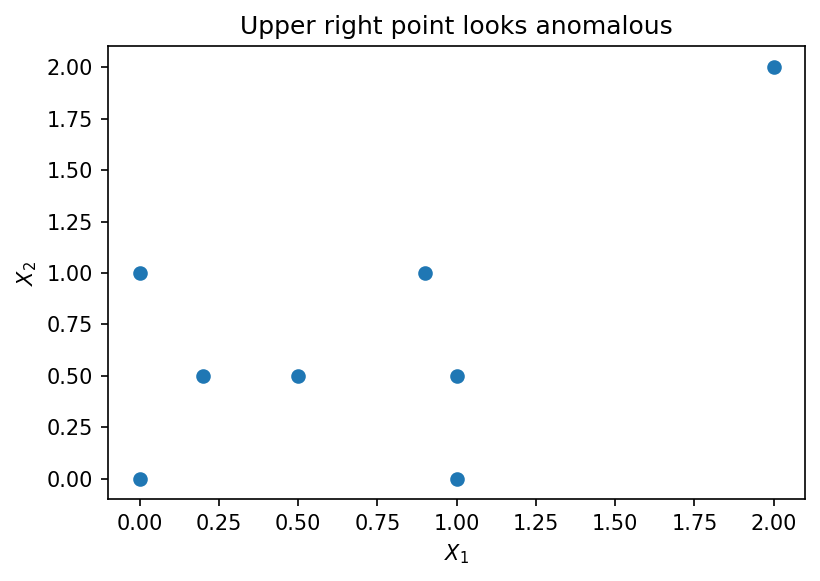

In [3]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point looks anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

Vamos criar uma função para visualizar um ponto de consulta e seus vizinhos mais explicitamente.

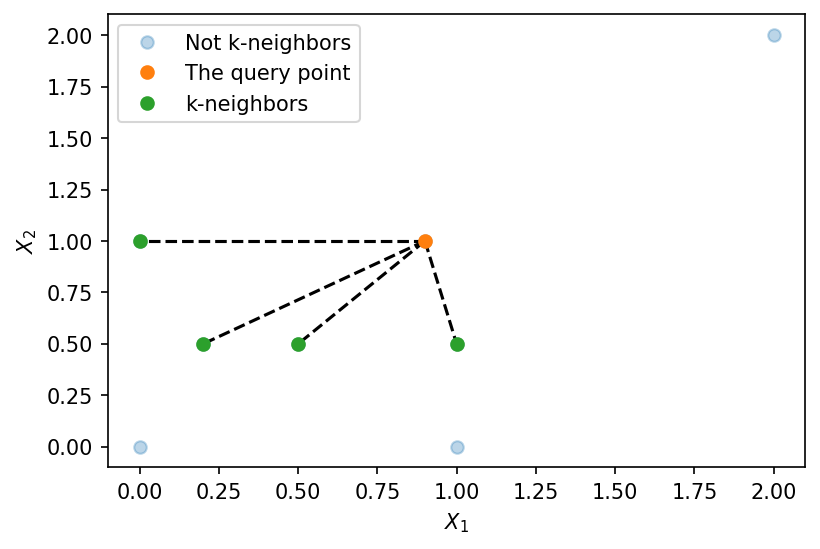

In [4]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    dist, index = nn.kneighbors()
    
    src_pt = X[highlight_index, :]
    
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    
# Example of usage
plot_point_and_k_neighbors(X, 0, 4)

Aqui podemos ver os 4 pontos próximos ao ponto de consulta (índice de 0 em nossos dados) são relativamente próximos. Vejamos o ponto anômalo no canto superior direito (este ponto tem um índice de 7):

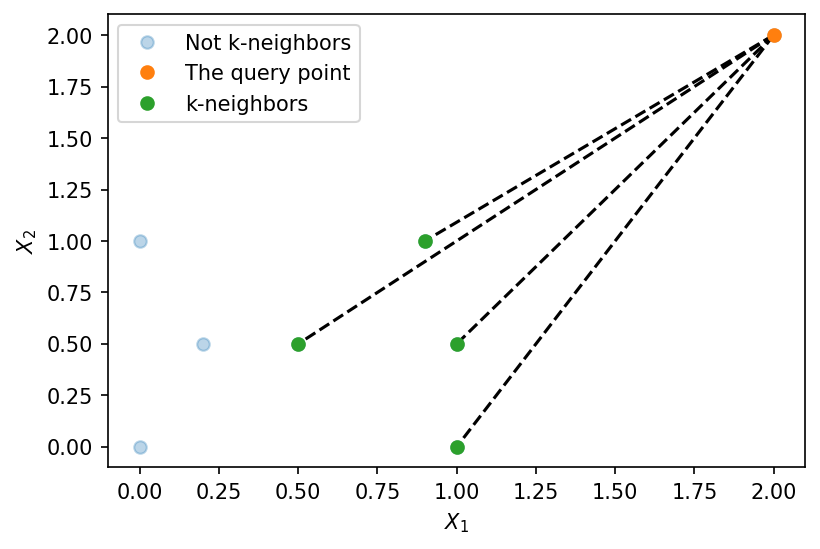

In [5]:
plot_point_and_k_neighbors(X, 7, n_neighbors=4)

Podemos ver, neste caso, que todos os quatro vizinhos mais próximos de nosso ponto estão distantes, portanto parece razoavelmente inequívoco chamar esse ponto de anomalia.

Vamos adicionar mais um ponto ao lado da anomalia e ver como a escolha de "k" e a função de pontuação afeta as coisas.

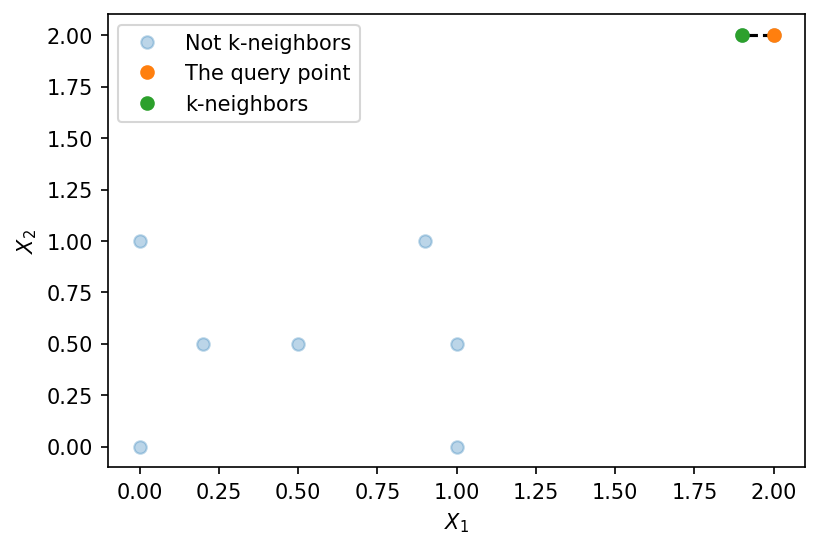

In [6]:
# Toy dataset with two adjacent anomalies
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Look at nearest neighbor (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

### Observação 1: dependência de $ k $

A distância entre o ponto 7 e o novo ponto é realmente muito pequena - menor que as distâncias entre qualquer par de pontos no canto inferior esquerdo. Se $ k = 1 $, os dois pontos no canto superior direito seriam os últimos a serem classificados como uma anomalia (ou seja, eles teriam a pontuação mais baixa).

### Observação 2: como ponderar distâncias?

Vejamos o mesmo conjunto de dados (ou seja, com o ponto adicional), mas agora vejamos $ k = 3 $

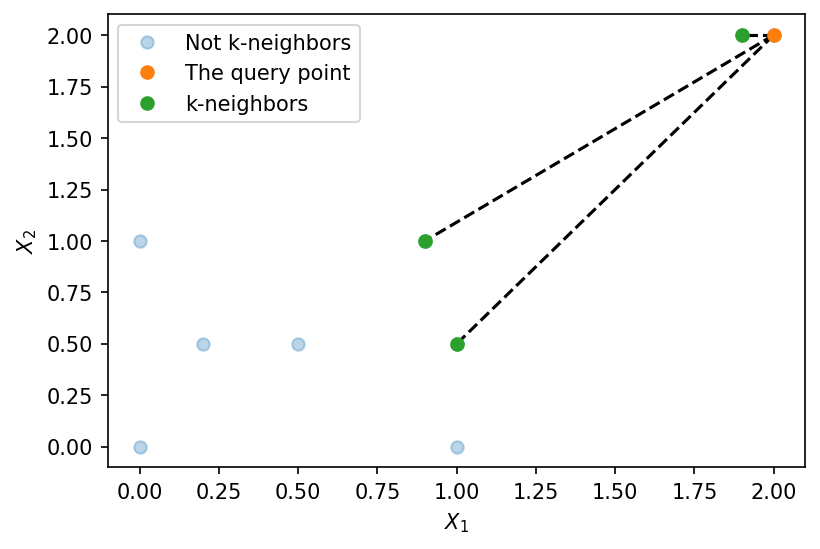

In [7]:
plot_point_and_k_neighbors(X2, 7, n_neighbors=3)

#Vemos que um dos três vizinhos mais próximos está muito perto, mas os outros dois estão longe. Precisamos de alguma maneira de combinar essas 3 distâncias em uma única pontuação. Os três métodos comumente usados são
1. Use a maior distância
2. Use a distância média (aritmética)
3. Use a média harmônica.

Implementaremos a maior distância e atribuiremos a distância média aritmética e a distância média harmônica como exercícios.

### Usando a maior distância

In [8]:
def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Gives the score of a point as the distance from point to its k-th nearest neighbor.
    Larger score means more likely to be an outlier
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists[:,-1]
    return scores

# Test 
do_nn_outlier_scores(X2, n_neighbors=3)

array([0.8602, 0.9   , 0.9434, 1.    , 0.6403, 0.5385, 0.5099, 1.8028,
       1.7493])

Podemos tornar a saída um pouco mais fácil de entender

In [9]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True)
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Look at the outliers using 3 neighbors
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Agora observe as anomalias com k = 1

In [10]:

print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


** TAKEAWAY: ** O número de vizinhos $ k $ usados no kNN altera drasticamente os resultados. Geralmente, é necessário algum conhecimento de domínio para saber o valor de $ k $ ou o intervalo de valores para que $ k $ seja usado.

## kNN ao contrário: detecção de outlier usando em grau (ODIN)


Outra variação baseada na distância, chamada ODIN (detecção de outlier usando em grau), usa os mesmos vizinhos de uma maneira diferente. Conforme discutido na lição, esse algoritmo faz a pergunta "quem sou eu o vizinho mais próximo?". Portanto, um exemplo que serve como NN de muitos outros - com muitos links de entrada no gráfico NN - tem uma pontuação de anomalia * baixa *. Exemplos com um pequeno grau (= número de links recebidos) têm mais probabilidade de serem anomalias.

Aqui está uma implementação do ODIN. Observe que convertemos as pontuações do valor indegree (baixo para uma anomalia) em uma escala de zero para um, onde valores mais altos são mais de anomalia.

In [11]:
def do_odin_outlier_scores(obs, n_neighbors=3):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(obs)
    graph = nn.kneighbors_graph()
    indegree = graph.sum(axis=0)  # sparse matrix

    # smaller indegree means more of an anomaly  
    # simple conversion to [0,1] so larger score is more of anomaly
    scores = (indegree.max() - indegree) / indegree.max()
    return np.array(scores)[0]  # convert to array

Marque e classifique os pontos para o conjunto de dados _X2_ (duas anomalias adjacentes).

In [12]:
scores_odin= do_odin_outlier_scores(X2)

In [13]:
print_ranked_scores(X2, scores_odin)

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.8333
  2.  [0. 0.]		0.8333
  3.  [2. 2.]		0.8333
  4.  [1.9 2. ]		0.8333
  5.  [1. 0.]		0.6667
  6.  [0.9 1. ]		0.1667
  7.  [0.2 0.5]		0.1667
  8.  [1.  0.5]		0.1667
  9.  [0.5 0.5]		0.0000


As duas anomalias (2, 2) e (1.9, 2) têm pontuações grandes, mas o mesmo acontece com os pontos (0, 1) e (0, 1). Além disso, o resultado é diferente do encontrado nos resultados de k-means. Como discutimos na palestra, o método que você usa é importante.

# Section 2: Cluster-Based Method (k-Means)

O armazenamento em cluster via k-means pode ser usado como um método de detecção de anomalias por:

   1. grupos geradores,
   2. encontrar o cluster de cada exemplo,
   3. usando a distância do exemplo ao centro do cluster como uma pontuação
  
Essas peças estão disponíveis usando o `cluster.KMeans` que, após o ajuste e a previsão de obtenção dos clusters - onde estão os clusters e a qual cluster um exemplo pertence - fornece um atributo` cluster_centers_`. Então podemos usar o `numpy.linalg.norm` de numpy (geralmente importado como` import numpy.linalg como nla`) para calcular as distâncias para nós.

Começaremos gerando alguns dados, mostrando quais são os clusters e, finalmente, pontuando as anomalias.


** Geração e visualização de dados **

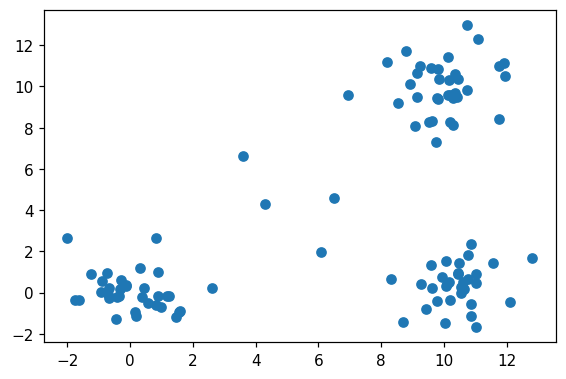

In [14]:
blobs_X, cluster_labels = sk_data.make_blobs(centers=[[0,0], [10,10], [10,0]])
anomalies, _ = sk_data.make_blobs(centers=[[5,5]], n_samples=5, cluster_std=3, random_state=42)

data = np.concatenate([blobs_X, anomalies])
cluster_labels = np.concatenate([cluster_labels, [-1]*len(anomalies)])

# Display the data before clustering
plt.figure(dpi=110)
plt.plot(data[:, 0], data[:, 1], 'o');

** Geração e visualização de dados **

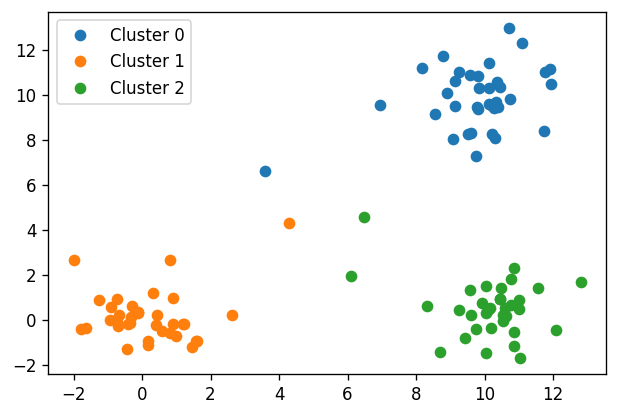

In [15]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

plt.figure(dpi=120)

for label in range(3):
    mask = (km.labels_ == label)
    plt.plot(data[mask, 0], data[mask, 1], 'o', label=f'Cluster {label}')
plt.legend();

Você deve executar o cluster várias vezes e observe que a atribuição de alguns pontos muda devido às diferentes condições iniciais (escolha aleatória dos centróides iniciais).

** Para cada ponto, encontre a distância do ponto ao centróide **

In [16]:
centers = km.cluster_centers_[km.labels_]
# show the centers for the first 10 points
centers[:10]

array([[10.1497,  0.5285],
       [ 9.7801,  9.8755],
       [ 0.2035,  0.1713],
       [10.1497,  0.5285],
       [ 0.2035,  0.1713],
       [ 0.2035,  0.1713],
       [ 0.2035,  0.1713],
       [ 9.7801,  9.8755],
       [ 9.7801,  9.8755],
       [ 0.2035,  0.1713]])

In [17]:
#Get the distances to the centers as use these as the scores
score = np.linalg.norm(data - centers, axis=1)
score

array([0.8675, 0.5049, 1.0469, 0.9285, 1.5847, 0.9801, 0.4402, 0.9114,
       1.5457, 0.665 , 2.4385, 0.4147, 1.9484, 1.2976, 2.0502, 2.7645,
       0.8982, 1.579 , 1.634 , 0.6732, 1.4992, 1.8331, 0.8886, 1.8101,
       0.4885, 2.5692, 2.2422, 3.3204, 0.9761, 1.6726, 0.4729, 0.49  ,
       1.4171, 1.6376, 1.8446, 0.5742, 0.4596, 4.3059, 0.7745, 1.009 ,
       1.6497, 0.2507, 0.3185, 1.1818, 2.4209, 1.257 , 0.9505, 0.9759,
       0.6066, 1.7631, 0.2516, 1.9461, 2.1004, 0.992 , 1.8429, 0.8704,
       2.4412, 0.0127, 2.0795, 1.1463, 0.8753, 0.1103, 0.6004, 0.8337,
       0.5202, 0.3453, 1.9945, 0.5285, 1.2973, 1.2064, 2.8962, 3.236 ,
       1.4513, 1.0221, 1.0068, 2.2796, 1.0838, 2.1787, 1.0723, 0.3663,
       1.0297, 0.73  , 0.6203, 1.911 , 0.6401, 1.1096, 0.6687, 0.781 ,
       0.7414, 0.714 , 1.1796, 1.0003, 1.0356, 1.7528, 0.4694, 0.6371,
       2.3793, 2.4858, 0.438 , 0.9514, 5.8127, 2.8535, 6.989 , 5.4635,
       2.5736])

Quais são os 5 pontos com as pontuações mais altas? Vamos chamar de anomalias

In [18]:

np.argsort(score)[::-1][:5]

array([102, 100, 103,  37,  27])

Mostre esses resultados em um gráfico que inclua os centros de cluster (rotulados com um 'x')

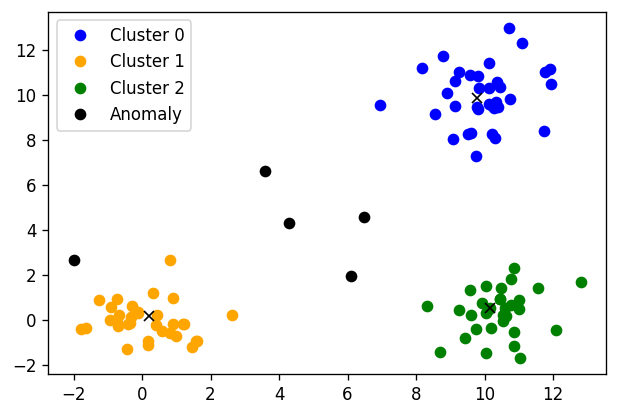

In [19]:

from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

anomaly_idx = np.argsort(score)[::-1][:5]
anomaly_mask = np.zeros(len(data))
anomaly_mask[anomaly_idx] = 1

plt.figure(dpi=120)
colors = ['blue', 'orange', 'green']

for label, color in enumerate(colors):
    mask = (km.labels_ == label) & (anomaly_mask == 0)
    plt.plot(data[mask, 0], data[mask, 1], marker='o', linestyle='none',
             color=color, label=f'Cluster {label}')
    plt.plot(*km.cluster_centers_[label], marker='x', color='k')

plt.plot(data[anomaly_idx, 0], data[anomaly_idx, 1], marker='o', linestyle='none',
         color='k', label='Anomaly')
plt.legend();

Se você executar novamente o cluster várias vezes, verá que os três pontos centrais são sempre rotulados como anomalias. As outras duas anomalias variam dependendo de como os pontos estão agrupados.

** Nota **: mudanças ainda maiores podem ser esperadas se o número de clusters for variado. A seguir, ilustramos o efeito da variação do número de clusters de 1 a 5.

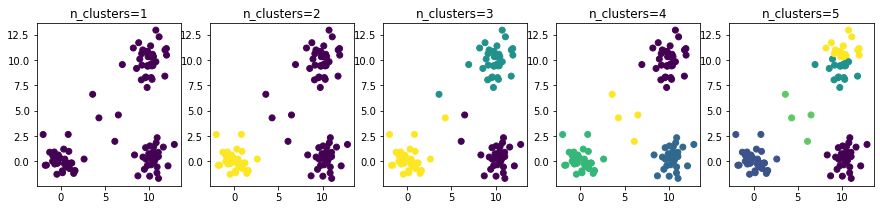

In [20]:
# Show clustering for user-specified number of clusters
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(15,3))
for ax, n_clusters in zip(axes, [1,2,3,4,5]):
    clust = KMeans(n_clusters=n_clusters)
    obs_to_clusters = clust.fit_predict(data) 
    ax.scatter(*data.T, c=obs_to_clusters)
    ax.set_title("n_clusters={}".format(n_clusters))

# Seção 3: Métodos baseados em densidade (fator externo externo)


O fator outlier local (LOF) é o `sklearn`, que possui uma versão disponível para uso. Observe que o LOF retornado por `sklearn` é o negativo do valor que definimos na palestra.

Aplique o LOF à coleção de pontos ('X2') que criamos na seção 1.

In [21]:
import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


Veja os valores acima e abaixo 1. Como discutido na palestra, esperamos que os valores significativamente acima de 1 sejam anomalias.

Compare com os resultados de kNN de antes. Observe que usamos o mesmo valor de k (= 3) para ambos os algoritmos.

In [22]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Os dois pontos anômalos são encontrados de qualquer maneira, mas há diferenças entre os resultados para os outros pontos.

Para completar, fornecemos abaixo uma implementação explícita do LOF que segue o esquema fornecido na palestra. Para verificar se nosso algoritmo é razoável, comparamos os resultados de sua pontuação de anomalia com os da versão `sklearn` para os blobs de cluster ('dados').

In [23]:
def lof_method(obs, n_neighbors=2):
    neigh = neighbors.NearestNeighbors(n_neighbors=2).fit(obs)
    
    #Return indices of and distances to the neighbors of each point
    topk_dist, my_kneigh = neigh.kneighbors()
    
    # Create list of distances of furthest (kth) neighbor 
    k_dist = topk_dist[:,-1]
 
    # Reachability distance: maximum of true distance between query neighbor and query point
    # and distance to kth nearest neighbor of query neighbor
    reach = np.maximum(topk_dist, k_dist[my_kneigh])
    
    # Local reacability density is reciprocal of average reachability distance
    lrd = 1.0 / np.mean(reach, axis=1)
    
    # Local outlier factor is given by
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)
    
    return lof

In [24]:
# Choose k=2
our_lof = lof_method(data, 2)
our_lof

array([0.9928, 0.9911, 1.7621, 1.0439, 1.0545, 1.1201, 1.0848, 0.894 ,
       0.9551, 1.2274, 1.4855, 1.5119, 0.9551, 1.5873, 1.9948, 1.5443,
       1.161 , 1.6177, 1.0988, 0.9607, 1.2111, 1.9853, 1.341 , 1.1899,
       0.9607, 1.8604, 0.9593, 4.175 , 0.782 , 1.7119, 1.5119, 1.2199,
       1.359 , 1.0842, 0.9749, 1.1345, 0.9911, 1.6368, 0.8366, 1.0198,
       1.1195, 1.4572, 1.6289, 1.2078, 4.5331, 0.9466, 1.1682, 0.994 ,
       1.0852, 0.9749, 0.8956, 1.2284, 1.6364, 0.8414, 1.1195, 1.3398,
       2.2636, 0.8956, 1.6364, 0.8915, 1.0882, 1.2638, 1.074 , 0.894 ,
       1.1018, 1.0581, 1.1965, 0.9726, 1.0029, 0.9612, 3.1355, 1.5443,
       1.2081, 1.1831, 1.3796, 1.0887, 0.9665, 2.9457, 1.3438, 0.9726,
       1.0562, 1.3445, 2.0296, 1.9948, 1.089 , 1.3707, 1.0091, 0.9665,
       0.9698, 1.0733, 0.9429, 1.0662, 1.0718, 1.0529, 0.9828, 1.0442,
       0.9389, 0.9593, 1.0108, 2.2963, 1.1264, 2.609 , 1.0735, 0.8944,
       1.5641])

In [25]:
lof2 = neighbors.LocalOutlierFactor(n_neighbors=2, contamination='auto')
lof2.fit(data)
sk_lof2 = -lof2.negative_outlier_factor_
print('Same as sklearn?', np.allclose(our_lof, sk_lof2))

Same as sklearn? True
